# End-to-End Optimisation

The notebook you have been provided contains code for a convolutional neural network and an image pre-processing and augmentation pipeline. The network and data pipeline are poorly optimised. Your task for this assignment is to analyse the performance of the network, in terms of training speed and the quality of the results, and then make improvements to the network based on your findings.

You will be training the model on the Oxford-IIIT pet dataset. The pipeline has a preprocessing function that performs some data augmentation. Consider how the pipeline can be made more efficient, use the Tensorboard Profiler tool to help—note you only need to profile a couple of batches, not the full training process.

The CNN uses a VGGNet architechture, built up with blocks of convolutional layers and maxpooling layers. Consider the settings of the existing layers, and whether additional layers can be added to improve the model accuracy, speed up learning, and tackle issues like over fitting. Research decisions around activation functions, optimiser settings.

Train the model as is at least once, and analyse the results—to speed up the notebook for future runs, you can save the weights and reload them to perform analysis. If you do save trhe weights, be sure to download them or store them in your google drive for easy access later on. The initial model could take up to an hour to run, so plan your time ahead.

You should create plots of the loss and metric curves, and to demonstrate the predictive capabilities of the model—think about what types of images the model is getting correct and what it is getting wrong.

You might want to add in callbacks to control modify training, but this isn't strictly necessary.

(I can't stress enough that this model and pipeline are *bad* and that is deliberate. It should just about learn *something* with no changes, but it won't do a good job. You can change anything in the code below, except for the block that loads the dataset—no training the model on a different set of images. You should be aiming to improve three key aspects in order to achieve full marks—training speed, accuracy of the training dataset, and accuracy of the validation/testing dataset.)

Your task for this assignment is to analyse the performance of the network, in terms of training speed and the quality of the results, and then make improvements to the network based on your findings.

1.	Train the network and plot the resulting loss functions and metrics. Create plots that demonstrate the predictive results of the network. Comment on these results in your report. (10 marks)
2.	Address the performance issues in the image processing pipeline, comment on the choices you make in your report. (10 marks)
3.	Adjust the design of the CNN to achieve improved predictive results, comment on the choices you make in your report. (10 marks)
4.	Change the settings used in training the network to improve both the training speed and predictive results. (5 marks)
5.	Train the new network, and repeat the analysis performed in the first step. Comment in your report how the changes you made have improved the speed and performance of the network. (10 marks)
Along with your completed Notebook, you should produce a 2-page report as detailed above. (5 marks for writing quality)


# Exercise 1 (10 marks)

Train the network and plot the resulting loss functions and metrics. Create plots that demonstrate the predictive results of the network. Comment on these results in your report. If you are worried about space in your report, you can number your plots inside the notebook and refer to those numbers in the text.

In [2]:
# Install the tensorflow addons package,
# which has a nice image rotation function
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.4 MB/s eta 0:00:00


In [3]:
# Import modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

import numpy as np

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
# Define some Important Variables
img_height = 128
img_width = 128
IMG_SIZE = (img_height,img_width)
BATCH_SIZE = 32
EPOCHS = 20

In [13]:
# Image Preprocessing functions. You should aim to optimise these in Exercise 2.

def img_process_train(features):
    """
    A preprocessing fuction for the training dataset. This function accepts the
    oxford_iiit_pet dataset, extracts the images and species label, the performs
    random augmentations before resizing and rescaling the images.
    """
    image = features['image']
    label = features['species']

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_contrast(image, 0.2, 0.5)
    image = tf.image.random_hue(image, 0.2)
    image = tf.image.random_jpeg_quality(image, 75, 95)
    image = tf.image.random_saturation(image, 5, 10)

    # Use tensorflow addons to randomly rotate images
    deg = np.random.uniform(-20,20)
    image = tfa.image.rotate(image, deg)

    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, 'float32')/255.

    return image, label

def img_process_test(features):
    """
    A preprocessing fuction for the test and validation datasets. This function
    accepts the oxford_iiit_pet dataset, extracts the images and species label,
    and resizes and rescales the images.
    """
    image = tf.image.resize(features['image'], IMG_SIZE)
    image = tf.cast(image, 'float32')/255.
    return image, features['species']


In [14]:
# Load the dataset

### DONT CHANGE ME ###
train_ds, val_ds, test_ds = tfds.load(
"oxford_iiit_pet",
split=["train[:100%]", "test[:50%]", "test[50%:100%]"],
)

### DONT CHANGE ME ###

# Set up the datasets with the augmentations and resizing
train_ds = train_ds.map(img_process_train).batch(BATCH_SIZE)
val_ds = val_ds.map(img_process_test).batch(BATCH_SIZE)
test_ds = test_ds.map(img_process_test).batch(BATCH_SIZE)

In [6]:
# Sequential Model Definition
def create_model_unoptimised():
    model = Sequential([
    layers.Input(shape=IMG_SIZE+(3,), name='Input'),
    layers.Conv2D(32, 4, padding='same', activation='relu',
                    name='Conv_1'),
    layers.Conv2D(32, 4, padding='same', activation='relu',
                    name='Conv_2'),
    layers.MaxPooling2D(name='Pool_1'),
    layers.Conv2D(64, 3, padding='same', activation='relu',
                    name='Conv_3'),
    layers.Conv2D(64, 3, padding='same', activation='relu',
                    name='Conv_4'),
    layers.MaxPooling2D(name='Pool_2'),
    layers.Flatten(name='Flatten'),
    layers.Dense(512, activation='relu', name='dense_1'),
    layers.Dense(1, name='Output')
    ], name='CNN')

    return model

In [7]:
# Create a version of the model and print the summary
model = create_model_unoptimised()

model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 128, 128, 32)      1568      
                                                                 
 Conv_2 (Conv2D)             (None, 128, 128, 32)      16416     
                                                                 
 Pool_1 (MaxPooling2D)       (None, 64, 64, 32)        0         
                                                                 
 Conv_3 (Conv2D)             (None, 64, 64, 64)        18496     
                                                                 
 Conv_4 (Conv2D)             (None, 64, 64, 64)        36928     
                                                                 
 Pool_2 (MaxPooling2D)       (None, 32, 32, 64)        0         
                                                                 
 Flatten (Flatten)           (None, 65536)             0       

In [8]:
# Adam optimiser
opt = tf.keras.optimizers.Adam()
# Binary classification loss
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Accuracy metric
metrics = ['accuracy']

# Compile model
model.compile(optimizer=opt,
              loss=loss_obj,
              metrics=metrics)


Epoch 1/20
115/115 [==============================] - 85s 616ms/step - loss: 0.6595 - accuracy: 0.5658 - val_loss: 0.6334 - val_accuracy: 0.5622
Epoch 2/20
115/115 [==============================] - 71s 618ms/step - loss: 0.6291 - accuracy: 0.6245 - val_loss: 0.6280 - val_accuracy: 0.6685
Epoch 3/20
115/115 [==============================] - 76s 659ms/step - loss: 0.6261 - accuracy: 0.6427 - val_loss: 0.6263 - val_accuracy: 0.6750
Epoch 4/20
115/115 [==============================] - 71s 617ms/step - loss: 0.6259 - accuracy: 0.6399 - val_loss: 0.6296 - val_accuracy: 0.5785
Epoch 5/20
115/115 [==============================] - 70s 613ms/step - loss: 0.6241 - accuracy: 0.6470 - val_loss: 0.6268 - val_accuracy: 0.6276
Epoch 6/20
115/115 [==============================] - 71s 618ms/step - loss: 0.6235 - accuracy: 0.6448 - val_loss: 0.6441 - val_accuracy: 0.4095
Epoch 7/20
115/115 [==============================] - 71s 614ms/step - loss: 0.6234 - accuracy: 0.6280 - val_loss: 0.6424 - val_ac

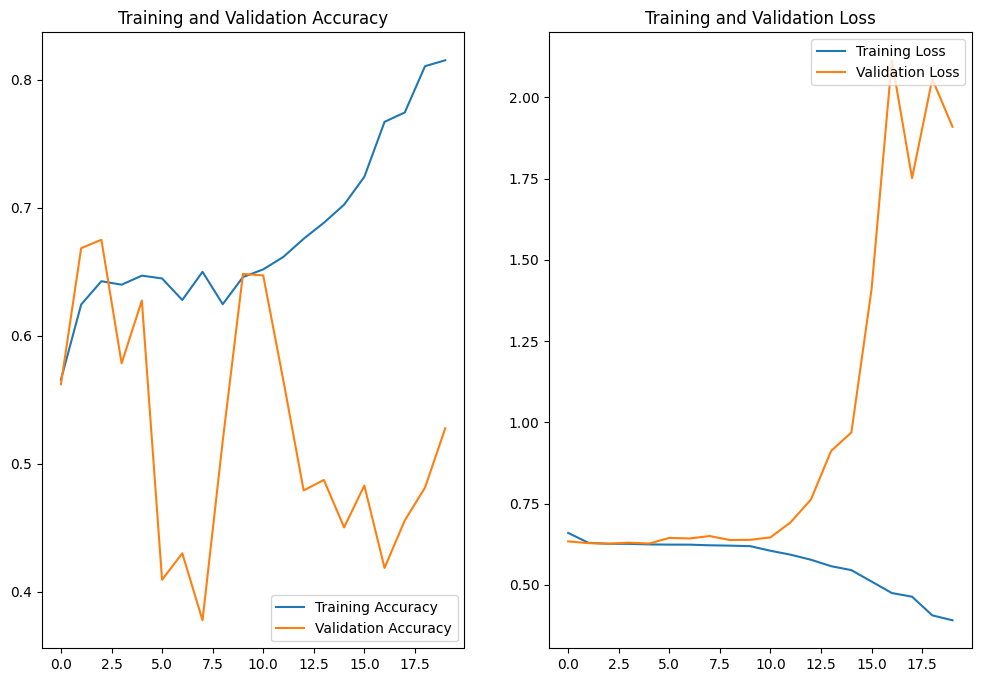

In [9]:
# Train the Model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS)
import matplotlib.pyplot as plt
# Plot the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Exercise 2 (10 marks)
Address the performance issues in the image processing pipeline, comment on the choices you make in your report.

You can copy the code above and make changes, or write the piepline from scratch. This could include creating new preprocessing functions.

Use this exercise to change the definitions of the training, validation and testing datasets to improve the speed at which the network trains, ***and*** predictive performance.

In [18]:
# Load the dataset

### DONT CHANGE ME ###
train_ds, val_ds, test_ds = tfds.load(
"oxford_iiit_pet",
split=["train[:100%]", "test[:50%]", "test[50%:100%]"],
)

### DONT CHANGE ME ###

In [8]:
### Edit the code below to improve the training speed and predictive performance
### of the network. Consider how to better implement the img_process_train and
### img_process test fuctions.

# Set up the datasets with the augmentations and resizing
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = (128, 128)  # Example image size, you can change as needed
BATCH_SIZE = 64  # Example batch size, adjust as needed

def img_process_train(features):
    """
    A preprocessing function for the training dataset. This function accepts a dictionary with keys 'image' and 'species',
    performs random augmentations before resizing and rescaling the image.
    """
    image = features['image']
    label = features['species']

    # Random augmentations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_contrast(image, 0.2, 0.5)
    image = tf.image.random_hue(image, 0.2)
    image = tf.image.random_jpeg_quality(image, 75, 95)
    image = tf.image.random_saturation(image, 5, 10)

    # Random rotation using tf.image
    image = tfa.image.rotate(image, tf.random.uniform([], -20 * np.pi / 180, 20 * np.pi / 180))

    # Resize and rescale
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0

    return image, label

def img_process_test(features):
    """
    A preprocessing function for the test and validation datasets. This function
    accepts a dictionary with keys 'image' and 'species', and resizes and rescales the image.
    """
    image = features['image']
    label = features['species']

    # Resize and rescale
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0

    return image, label

In [19]:
train_ds = train_ds.map(lambda x: img_process_train(x), num_parallel_calls=tf.data.AUTOTUNE)\
                   .batch(BATCH_SIZE)\
                   .prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(lambda x: img_process_test(x), num_parallel_calls=tf.data.AUTOTUNE)\
               .batch(BATCH_SIZE)\
               .prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(lambda x: img_process_test(x), num_parallel_calls=tf.data.AUTOTUNE)\
                 .batch(BATCH_SIZE)\
                 .prefetch(tf.data.AUTOTUNE)

# Exercise 3 (10 marks)
Adjust the design of the CNN to achieve improved predictive results, comment on the choices you make in your report.

You can add in new layers, change the settings of the existing layers. You could even use a different CNN architecture. Consider how the layer settings contribute to slowing down the network, such as with very large calculations with high numbers of traininable parameters.

Comment on any changes you make in your report, including details of any tests you performed. You might find it useful to create a new notebook specifically for testing different models, so that this notebook doesn't get too clogged up with outputs.

In [16]:
### Change the model architecture to improve both the training speed and
### predictive performance

def create_model_optimised():
    model = Sequential([
        layers.Input(shape=IMG_SIZE + (3,), name='Input'),
        layers.Conv2D(32, 3, padding='same', activation='relu', name='Conv_1'),
        layers.BatchNormalization(name='BN_1'),
        layers.Conv2D(32, 3, padding='same', activation='relu', name='Conv_2'),
        layers.BatchNormalization(name='BN_2'),
        layers.MaxPooling2D(name='Pool_1'),
        layers.Dropout(0.25, name='Dropout_1'),

        layers.Conv2D(64, 3, padding='same', activation='relu', name='Conv_3'),
        layers.BatchNormalization(name='BN_3'),
        layers.Conv2D(64, 3, padding='same', activation='relu', name='Conv_4'),
        layers.BatchNormalization(name='BN_4'),
        layers.MaxPooling2D(name='Pool_2'),
        layers.Dropout(0.25, name='Dropout_2'),

        layers.Conv2D(128, 3, padding='same', activation='relu', name='Conv_5'),
        layers.BatchNormalization(name='BN_5'),
        layers.Conv2D(128, 3, padding='same', activation='relu', name='Conv_6'),
        layers.BatchNormalization(name='BN_6'),
        layers.MaxPooling2D(name='Pool_3'),
        layers.Dropout(0.25, name='Dropout_3'),

        layers.Flatten(name='Flatten'),
        layers.Dense(512, activation='relu', name='Dense_1'),
        layers.BatchNormalization(name='BN_7'),
        layers.Dropout(0.5, name='Dropout_4'),
        layers.Dense(1, activation='sigmoid', name='Output')
    ], name='Optimized_CNN')

    return model

# Create the model
model_1 = create_model_optimised()

# Print the model summary
model_1.summary()

Model: "Optimized_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 BN_1 (BatchNormalization)   (None, 128, 128, 32)      128       
                                                                 
 Conv_2 (Conv2D)             (None, 128, 128, 32)      9248      
                                                                 
 BN_2 (BatchNormalization)   (None, 128, 128, 32)      128       
                                                                 
 Pool_1 (MaxPooling2D)       (None, 64, 64, 32)        0         
                                                                 
 Dropout_1 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 Conv_3 (Conv2D)             (None, 64, 64, 64)      

# Exercise 4 (5 marks)

Change the settings used in training the network to improve both the training speed and predictive results.

Consider how you might compile the model with different settings, how many epochs the model needs to be trained for, how learning rates and batch sizes might affect training.

In [ ]:
### Experiment with the training settings to maximise the predictive performance
### of the network

# Adam optimizer
optimizer = tf.keras.optimizers.AdamW(learning_rate= 0.001)

# Compile model
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.00001)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


# Exercise 5 (10 marks)

Train the new network, and repeat the analysis performed in the first step. Comment in your report how the changes you made have improved the speed and performance of the network.

In [ ]:
# Define some Important Variables
img_height = 128
img_width = 128
IMG_SIZE = (img_height,img_width)
BATCH_SIZE = 64
EPOCHS = 40

In [ ]:
# Image Preprocessing functions. You should aim to optimise these in Exercise 2.

def img_process_train(features):
    """
    A preprocessing fuction for the training dataset. This function accepts the
    oxford_iiit_pet dataset, extracts the images and species label, the performs
    random augmentations before resizing and rescaling the images.
    """
    image = features['image']
    label = features['species']

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_contrast(image, 0.2, 0.5)
    image = tf.image.random_hue(image, 0.2)
    image = tf.image.random_jpeg_quality(image, 75, 95)
    image = tf.image.random_saturation(image, 5, 10)

    # Use tensorflow addons to randomly rotate images
    deg = np.random.uniform(-20,20)
    image = tfa.image.rotate(image, deg)

    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, 'float32')/255.

    return image, label

def img_process_test(features):
    """
    A preprocessing fuction for the test and validation datasets. This function
    accepts the oxford_iiit_pet dataset, extracts the images and species label,
    and resizes and rescales the images.
    """
    image = tf.image.resize(features['image'], IMG_SIZE)
    image = tf.cast(image, 'float32')/255.
    return image, features['species']


In [ ]:
# Load the dataset

### DONT CHANGE ME ###
train_ds, val_ds, test_ds = tfds.load(
"oxford_iiit_pet",
split=["train[:100%]", "test[:50%]", "test[50%:100%]"],
)

In [ ]:
train_ds = train_ds.map(lambda x: img_process_train(x), num_parallel_calls=tf.data.AUTOTUNE)\
                   .batch(BATCH_SIZE)\
                   .prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(lambda x: img_process_test(x), num_parallel_calls=tf.data.AUTOTUNE)\
               .batch(BATCH_SIZE)\
               .prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(lambda x: img_process_test(x), num_parallel_calls=tf.data.AUTOTUNE)\
                 .batch(BATCH_SIZE)\
                 .prefetch(tf.data.AUTOTUNE)

In [5]:
def create_model_optimised():
    model = Sequential([
        layers.Input(shape=IMG_SIZE + (3,), name='Input'),
        layers.Conv2D(32, 3, padding='same', activation='relu', name='Conv_1'),
        layers.BatchNormalization(name='BN_1'),
        layers.Conv2D(32, 3, padding='same', activation='relu', name='Conv_2'),
        layers.BatchNormalization(name='BN_2'),
        layers.MaxPooling2D(name='Pool_1'),
        layers.Dropout(0.25, name='Dropout_1'),

        layers.Conv2D(64, 3, padding='same', activation='relu', name='Conv_3'),
        layers.BatchNormalization(name='BN_3'),
        layers.Conv2D(64, 3, padding='same', activation='relu', name='Conv_4'),
        layers.BatchNormalization(name='BN_4'),
        layers.MaxPooling2D(name='Pool_2'),
        layers.Dropout(0.25, name='Dropout_2'),

        layers.Conv2D(128, 3, padding='same', activation='relu', name='Conv_5'),
        layers.BatchNormalization(name='BN_5'),
        layers.Conv2D(128, 3, padding='same', activation='relu', name='Conv_6'),
        layers.BatchNormalization(name='BN_6'),
        layers.MaxPooling2D(name='Pool_3'),
        layers.Dropout(0.25, name='Dropout_3'),

        layers.Flatten(name='Flatten'),
        layers.Dense(512, activation='relu', name='Dense_1'),
        layers.BatchNormalization(name='BN_7'),
        layers.Dropout(0.5, name='Dropout_4'),
        layers.Dense(1, activation='sigmoid', name='Output')
    ], name='Optimized_CNN')

    return model

# Create the model
model_1 = create_model_optimised()

# Compile the model
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model_1.summary()

Model: "Optimized_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 BN_1 (BatchNormalization)   (None, 128, 128, 32)      128       
                                                                 
 Conv_2 (Conv2D)             (None, 128, 128, 32)      9248      
                                                                 
 BN_2 (BatchNormalization)   (None, 128, 128, 32)      128       
                                                                 
 Pool_1 (MaxPooling2D)       (None, 64, 64, 32)        0         
                                                                 
 Dropout_1 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 Conv_3 (Conv2D)             (None, 64, 64, 64)      

In [ ]:
# Train the Model
history = model_1.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS)

Epoch 1/40
58/58 [==============================] - 69s 1s/step - loss: 0.9277 - accuracy: 0.5516 - val_loss: 0.6326 - val_accuracy: 0.6750
Epoch 2/40
58/58 [==============================] - 62s 1s/step - loss: 0.7576 - accuracy: 0.6209 - val_loss: 0.6315 - val_accuracy: 0.6750
Epoch 3/40
58/58 [==============================] - 59s 1s/step - loss: 0.7275 - accuracy: 0.6313 - val_loss: 0.6351 - val_accuracy: 0.6750
Epoch 4/40
58/58 [==============================] - 65s 1s/step - loss: 0.7288 - accuracy: 0.6209 - val_loss: 0.6454 - val_accuracy: 0.6718
Epoch 5/40
58/58 [==============================] - 61s 1s/step - loss: 0.6947 - accuracy: 0.6302 - val_loss: 0.6345 - val_accuracy: 0.6756
Epoch 6/40
58/58 [==============================] - 59s 1s/step - loss: 0.6831 - accuracy: 0.6334 - val_loss: 0.6464 - val_accuracy: 0.6663
Epoch 7/40
58/58 [==============================] - 61s 1s/step - loss: 0.6634 - accuracy: 0.6462 - val_loss: 0.6412 - val_accuracy: 0.6658
Epoch 8/40
58/58 [==

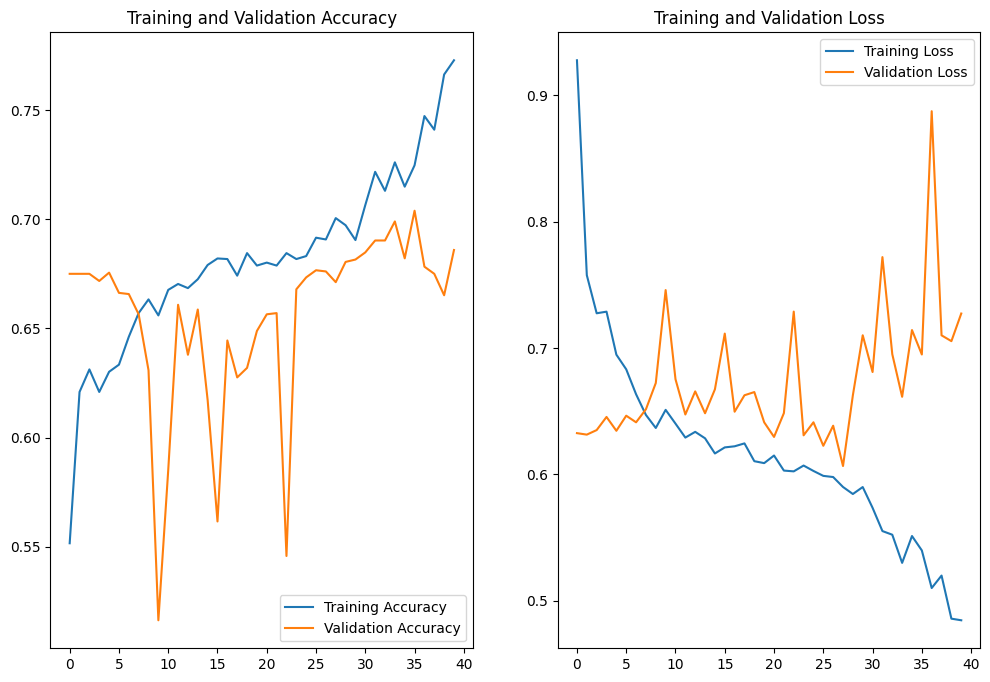

In [21]:
# Plot the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
